In [1]:
import db_loader
from db_loader import BistroDB
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [2]:
database = BistroDB('DATABASE_NAME', 'DATABASE_USER_NAME', 'DATABASE_KEY', 'DATABASE_HOST')

Connected to DB at 13.56.123.155


In [3]:
simulations = database.load_simulation_df()
simulations.tail()

,simulation_id,datetime,scenario,name,tag
1501,7b6c7e48-a91b-11ea-9534-063f0fd82f9f,2020-01-27 20:17:03,sioux_faux-15k,5e2f44a754eafa4e9a396ff3,OPTMIZATION_Agg6
1502,78e53b66-a91a-11ea-9534-063f0fd82f9f,2020-01-20 07:54:12,sioux_faux-15k,5e2559860dae651f867be221,OPTMIZATION_Agg7
1503,7b6c7e48-a91b-11ea-9534-063f0fd82f9f,2020-01-27 20:17:03,sioux_faux-15k,5e2f44a754eafa4e9a396ff3,OPTMIZATION_Agg8
1504,5ae2266c-9d5b-11ea-86be-acde48001122,2020-05-23 18:10:17,sioux_faux-15k,siouxfaux_15k_BAU,None
1505,790458ce-adb2-11ea-9534-063f0fd82f9f,2020-01-27 10:46:22,sioux_faux-15k,5e2eb80c54eafa4e9a396fc0,None


In [6]:
simulations = database.load_simulation_df()
sample_simulation = simulations[simulations['simulation_id'] == '790458ce-adb2-11ea-9534-063f0fd82f9f']
sample_simulation

,simulation_id,datetime,scenario,name,tag
1505,790458ce-adb2-11ea-9534-063f0fd82f9f,2020-01-27 10:46:22,sioux_faux-15k,5e2eb80c54eafa4e9a396fc0,None


In [13]:
# add to the list of IDs if more than one simulation need to be compared at once
# 5ae2266c-9d5b-11ea-86be-acde48001122

simulation_id = ['790458ce-adb2-11ea-9534-063f0fd82f9f']
# ['5ae2266c-9d5b-11ea-86be-acde48001122']
#['790458ce-adb2-11ea-9534-063f0fd82f9f']
#
#['44402ee0-7cb8-11ea-a911-063f0fd82f9f']
#['790458ce-adb2-11ea-9534-063f0fd82f9f']

scenario = 'sioux_faux-15k'

In [23]:
path = database.load_paths(simulation_id, scenario)
path['duration(s)'] = path['arrivalTime'] - path['departureTime']

path['departureTime'] = pd.to_datetime(path['departureTime'], unit='s').dt.strftime("%H:%M:%S")
path['arrivalTime'] = pd.to_datetime(path['arrivalTime'], unit='s').dt.strftime("%H:%M:%S")
path['speed(mph)'] = path['distance'] / path['duration(s)']*2.23694

path = path.sort_values(by=['speed(mph)'])
path = path[path['mode'] == 'car']

path.head()

,vehicle,distance,mode,departureTime,arrivalTime,numPassengers,fuelCost,fuelConsumed,start_x,start_y,end_x,end_y,vehicleType,duration(s),speed(mph)
3223,1638-2,246.785,car,18:06:34,18:14:50,0,0.038388,1.279596e+06,-96.731259,43.515546,-96.731257,43.514878,CAR-TYPE-DEFAULT,496,1.112990
10363,3036-1,217.632,car,16:48:23,16:55:40,0,0.033853,1.128436e+06,-96.779448,43.514826,-96.781377,43.514824,CAR-TYPE-DEFAULT,437,1.114027
17971,4562-2,217.632,car,16:46:43,16:54:00,0,0.033853,1.128436e+06,-96.779448,43.514826,-96.782149,43.514825,CAR-TYPE-DEFAULT,437,1.114027
22633,5503-1,160.066,car,17:44:35,17:49:56,0,0.024899,8.299526e+05,-96.731294,43.526131,-96.731291,43.524690,CAR-TYPE-DEFAULT,321,1.115446
8027,2554-4,200.512,car,19:58:49,20:05:31,0,0.031190,1.039668e+06,-96.731237,43.513074,-96.731237,43.513074,CAR-TYPE-DEFAULT,402,1.115755


In [55]:
path['origin'] = gpd.points_from_xy(path.start_y, path.start_x)
path['destination'] = gpd.points_from_xy(path.end_y, path.end_x)
path_o_d = path.drop(['start_x', 'start_y', 'end_x', 'end_y', 'numPassengers', 
                      'duration(s)', 'mode', 'fuelConsumed', 'fuelCost'], axis=1)

# convert o-d pairs into linestring obj
path_o_d['line'] = path_o_d.apply(lambda x: LineString([x['origin'], x['destination']]), axis=1)

print(path_o_d.isna().sum())
path_o_d = path_o_d.dropna()

vehicle           0
distance          0
departureTime     0
arrivalTime       0
vehicleType       0
speed(mph)       45
origin            0
destination       0
line              0
dtype: int64


In [56]:
path_o_d.head()

,vehicle,distance,departureTime,arrivalTime,vehicleType,speed(mph),origin,destination,line
36722,5485-3,14.805,08:03:42,08:04:12,CAR-TYPE-DEFAULT,1.103930,POINT (43.518514 -96.7461474),POINT (43.5186468 -96.7511248),"LINESTRING (43.518514 -96.7461474, 43.5186468 ..."
111525,rideHailVehicle-401-2014000293639-068469,22.255,12:35:00,12:35:45,BEV,1.106291,POINT (43.5390647 -96.7312986),POINT (43.5390647 -96.7312986),"LINESTRING (43.5390647 -96.7312986, 43.5390647..."
111061,rideHailVehicle-1500-2016000262140-0130936,22.255,12:17:30,12:18:15,BEV,1.106291,POINT (43.5390647 -96.7312986),POINT (43.5390647 -96.7312986),"LINESTRING (43.5390647 -96.7312986, 43.5390647..."
38962,5761-3,27.806,18:06:30,18:07:26,CAR-TYPE-DEFAULT,1.110721,POINT (43.5019613 -96.7710324),POINT (43.5050251 -96.77103510000001),"LINESTRING (43.5019613 -96.7710324, 43.5050251..."
26594,4263-1,26.859,08:02:54,08:03:48,CAR-TYPE-DEFAULT,1.112629,POINT (43.5152248 -96.7510808),POINT (43.5186468 -96.7511248),"LINESTRING (43.5152248 -96.7510808, 43.5186468..."


In [57]:
path_o_d['speed(mph)'].describe()

count    47421.000000
mean         7.807260
std          3.798863
min          1.103930
25%          5.009551
50%          7.780311
75%         10.309535
max         41.006211
Name: speed(mph), dtype: float64

In [58]:
# Filter by time periods for vis

path_am_peak = path_o_d[(path_o_d['departureTime'] >= '07:00:00') & (path_o_d['departureTime'] <= '10:00:00')]
path_pm_peak = path_o_d[(path_o_d['departureTime'] >= '17:00:00') & (path_o_d['departureTime'] <= '20:00:00')]
path_am_peak_gpd = gpd.GeoDataFrame(path_am_peak, geometry=path_am_peak['line'])
path_pm_peak_gpd = gpd.GeoDataFrame(path_pm_peak, geometry=path_pm_peak['line'])

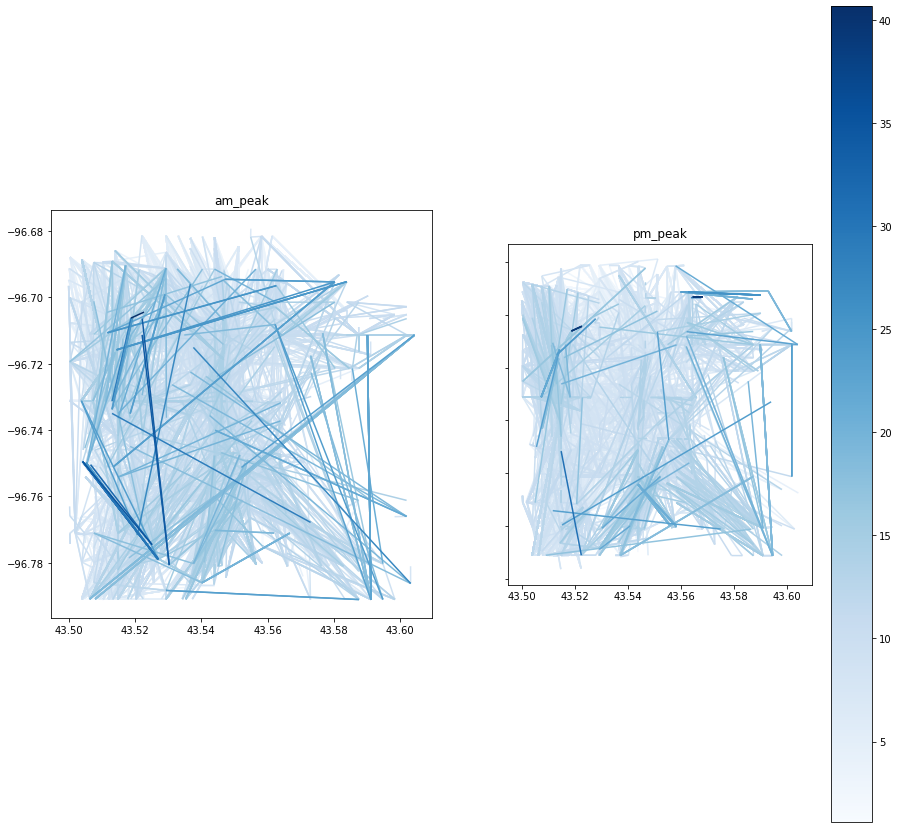

In [59]:
fig, axs = plt.subplots(1, 2, figsize = [15, 15])
for ax in fig.get_axes():
    ax.label_outer()
    
axs[0].set_title('am_peak')
axs[1].set_title('pm_peak')
ax0 = path_am_peak_gpd.plot(column='speed(mph)', ax=axs[0], cmap = 'Blues')
ax1 = path_pm_peak_gpd.plot(column='speed(mph)', ax=axs[1], cmap = 'Blues', legend=True)
# fig.colorbar(ax0, ax=[axs[0], axs[1]])

----

## Notes
1. `pathtraversal` table should be indexed by vehicles for a groups of links per path, a particular path should only have one vehicle type.
2. `beam` outputs `[start_x, start_y, end_x, end_y]` columns, which could be slightly different from what the actual destination/origin coordinates are. While being different, they are the origin-destinations of the entire path rather than specfic to each link.
3. A `leg` of the trip may contain multiple paths, which then have groups of links, if a vehicle type is changed, it's gong to be a new leg of the trip.
4. **As you can see from the mess above,** this is actually the plot of the paths in a straight line, using the origin-destinations from the beam output.

The cells below is going to explore the modified sql `parsing load_path()` from `db_loader.py`, which joins with the `pathtraversal_link` table for the origin-destination from the fixed data. Instead of grouping the links, I'm going to leave the repetetive rows for graphing proposes, which would map each link with the entire path's speed, which effect should be negligible due to the (relative) short length of each path.

---

In [14]:
path_w_links = database.load_paths(simulation_id, scenario, True)
links = database.load_links(scenario)

path_w_links['duration(s)'] = path_w_links['arrivalTime'] - path_w_links['departureTime']
path_w_links['speed(mph)'] = path_w_links['distance'] / path_w_links['duration(s)']*2.23694

path_w_links['departureTime'] = pd.to_datetime(path_w_links['departureTime'], unit='s').dt.strftime("%H:%M:%S")
path_w_links['arrivalTime'] = pd.to_datetime(path_w_links['arrivalTime'], unit='s').dt.strftime("%H:%M:%S")

path_w_links = path_w_links.sort_values(by=['speed(mph)'])
path_w_links = path_w_links[path_w_links['mode'] == 'car']

In [27]:
a = database.load_paths(simulation_id, scenario)
a['mode'].unique()

array(['car', 'walk', 'bus'], dtype=object)

In [24]:
print(path['speed(mph)'].describe())
print(path['duration(s)'].describe())
print(path['distance'].describe())

count    28263.000000
mean         9.089380
std          3.155634
min          1.112990
25%          7.700364
50%          9.310312
75%         10.335383
max         39.672475
Name: speed(mph), dtype: float64
count    28300.000000
mean       495.612968
std        675.957439
min          0.000000
25%         78.000000
50%        187.000000
75%        669.000000
max       6083.000000
Name: duration(s), dtype: float64
count    28300.000000
mean      1628.981854
std       1896.200126
min          0.000000
25%        308.774000
50%        502.225500
75%       2499.391500
max      26174.596000
Name: distance, dtype: float64


In [21]:
path_w_links.head()

,vehicle,distance,mode,departureTime,arrivalTime,numPassengers,fuelCost,fuelConsumed,LinkId,vehicleType,duration(s),speed(mph)
34176,1638-2,246.785,car,18:06:34,18:14:50,0,0.038388,1.279596e+06,992,CAR-TYPE-DEFAULT,496,1.112990
34177,1638-2,246.785,car,18:06:34,18:14:50,0,0.038388,1.279596e+06,2204,CAR-TYPE-DEFAULT,496,1.112990
34178,1638-2,246.785,car,18:06:34,18:14:50,0,0.038388,1.279596e+06,4704,CAR-TYPE-DEFAULT,496,1.112990
34179,1638-2,246.785,car,18:06:34,18:14:50,0,0.038388,1.279596e+06,4782,CAR-TYPE-DEFAULT,496,1.112990
190468,4562-2,217.632,car,16:46:43,16:54:00,0,0.033853,1.128436e+06,2718,CAR-TYPE-DEFAULT,437,1.114027


In [ ]:
merged_path_w_links = path_w_links.join(links.set_index('LinkId'), on='LinkId')
merged_path_w_links['origin'] = gpd.points_from_xy(merged_path_w_links.fromLocationX, merged_path_w_links.fromLocationY)
merged_path_w_links['destination'] = gpd.points_from_xy(merged_path_w_links.toLocationX, merged_path_w_links.toLocationY)
merged_path_w_links = merged_path_w_links.drop(['fromLocationX', 'fromLocationY', 'toLocationX', 'toLocationY', 
                                               'numPassengers', 'duration(s)', 'mode', 'fuelConsumed', 
                                                'fuelCost'], axis=1)
merged_path_w_links['line'] = merged_path_w_links.apply(lambda x: LineString([x['origin'], x['destination']]), axis=1)

print(merged_path_w_links.isna().sum())
merged_path_w_links = merged_path_w_links.dropna()

In [ ]:
print(merged_path_w_links['speed(mph)'].describe())
print()
print(merged_path_w_links['freespeed'].describe())

In [ ]:
merged_path_w_links.head()

In [ ]:
am_peak = merged_path_w_links[(merged_path_w_links['departureTime'] >= '07:00:00') 
                              & (merged_path_w_links['departureTime'] <= '10:00:00')]
pm_peak = merged_path_w_links[(merged_path_w_links['departureTime'] >= '17:00:00') 
                              & (merged_path_w_links['departureTime'] <= '20:00:00')]
am_peak_gpd = gpd.GeoDataFrame(am_peak, geometry=am_peak['line'])
pm_peak_gpd = gpd.GeoDataFrame(pm_peak, geometry=pm_peak['line'])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = [20, 20])
for ax in fig.get_axes():
    ax.label_outer()
    
axs[0].set_title('am_peak')
axs[1].set_title('pm_peak')
ax0 = am_peak_gpd.plot(column='speed(mph)', ax=axs[0], cmap = 'Blues')
ax1 = pm_peak_gpd.plot(column='speed(mph)', ax=axs[1], cmap = 'Blues', legend=True)
# fig.colorbar(ax0, ax=[axs[0], axs[1]])

In [ ]:
legs_links = database.load_legs(simulation_id, links=True)
legs_links.head()

-------

In [ ]:
shape = shape.drop(['origin', 'destination'], axis=1)
shape.to_file('sample.shp')

----

## Checking speed stats for all simulations on the database

In [4]:
simulations = database.load_simulation_df()
simulations.head()

,simulation_id,datetime,scenario,name,tag
0,44402ee0-7cb8-11ea-a911-063f0fd82f9f,2019-11-19 08:39:28,sioux_faux-15k,5dd3a7ae354c574b93c68c8e,RS_MILEAGE_CB_work_CB_2ndary_1
1,6a9bfb90-7cc3-11ea-a911-063f0fd82f9f,2019-11-21 18:52:48,sioux_faux-15k,5dd6dca459ca2a5c5a39b25f,RS_MILEAGE_CB_work_CB_2ndary_2
2,63b65d06-7cb5-11ea-a911-063f0fd82f9f,2019-11-19 17:18:00,sioux_faux-15k,5dd423958d0e0e0d0e6b73d2,RS_MILEAGE_CB_work_CB_2ndary_3
3,c6291868-7cd1-11ea-a911-063f0fd82f9f,2019-11-19 22:50:08,sioux_faux-15k,5dd471548d0e0e0d0e6b73f2,RS_MILEAGE_CB_work_CB_2ndary_4
4,549b8db0-7caf-11ea-a911-063f0fd82f9f,2019-11-21 15:26:56,sioux_faux-15k,5dd6a23d59ca2a5c5a39b249,RS_MILEAGE_CB_work_CB_2ndary_5


In [20]:
path['speed(mph)'].describe()

count    301753.000000
mean          9.199231
std           3.707072
min           1.112990
25%           7.461594
50%           9.321836
75%          10.828440
max          39.672475
Name: speed(mph), dtype: float64

In [32]:
simulations = database.load_simulation_df()

In [33]:
simulation_ids = simulations['simulation_id']
col_names =  ['simulation_id', 'tag', 'mean', 'min', '25%', '50%', '75%', 'max']
speed_stats  = pd.DataFrame(columns = col_names)

for id in simulation_ids:
    # load the simulation
    simulation = simulations[simulations['simulation_id'] == id]
    
    # get the path table without links
    pathtraversal = database.load_paths([id], scenario)
    
    # add the speed as a new colmn
    pathtraversal = pathtraversal[pathtraversal['mode'] == 'car']
    pathtraversal['duration(s)'] = pathtraversal['arrivalTime'] - pathtraversal['departureTime']
    pathtraversal['speed(mph)'] = (pathtraversal['distance'] / pathtraversal['duration(s)'])*2.23694
    
    #tag
    tag = simulation['tag']
    # mean
    mean = pathtraversal['speed(mph)'].describe()[1]
    # min
    mini = pathtraversal['speed(mph)'].describe()[3]
    # 25%
    twenty_five = pathtraversal['speed(mph)'].describe()[4]
    # median
    median = pathtraversal['speed(mph)'].describe()[5]
    # 75%
    seventy_five = pathtraversal['speed(mph)'].describe()[6]
    # max
    maxi = pathtraversal['speed(mph)'].describe()[7]
    speed_stats.loc[len(pathtraversal)] = [id, tag, mean, mini, twenty_five, median, seventy_five, maxi]    

In [34]:
speed_stats.head()

,simulation_id,tag,mean,min,25%,50%,75%,max
50264,44402ee0-7cb8-11ea-a911-063f0fd82f9f,0 RS_MILEAGE_CB_work_CB_2ndary_1 94 ...,8.679485,1.095604,7.322654,8.427047,10.339311,39.672475
50076,6a9bfb90-7cc3-11ea-a911-063f0fd82f9f,1 RS_MILEAGE_CB_work_CB_2ndary_2 96 ...,8.755065,1.080621,7.551533,8.525433,10.335383,39.672475
50454,63b65d06-7cb5-11ea-a911-063f0fd82f9f,2 RS_MILEAGE_CB_work_CB_2ndary_3 97 ...,8.910425,1.080621,7.662272,8.721904,10.350321,39.672475
50066,c6291868-7cd1-11ea-a911-063f0fd82f9f,3 RS_MILEAGE_CB_work_CB_2ndary_4 241 ...,8.749131,1.080621,7.498359,8.455514,10.349664,39.672475
2504,a9d10d72-7cd8-11ea-a911-063f0fd82f9f,5 RS_MILEAGE_CB_work_CB_2ndary_6 6 ...,10.397922,5.700401,7.752747,10.223095,13.052084,38.260125


In [35]:
speed_stats['max'].describe()

count    244.000000
mean      39.639353
std        0.237781
min       38.260125
25%       39.672475
50%       39.672475
75%       39.672475
max       41.006211
Name: max, dtype: float64

In [36]:
speed_stats['mean'].describe()

count    244.000000
mean       9.143293
std        0.604569
min        7.682488
25%        8.688889
50%        8.964710
75%        9.644099
max       10.397922
Name: mean, dtype: float64